## import module

In [1]:
!pip install d2l

In [2]:
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albu

In [3]:
%matplotlib inline  
#notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게

import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
torch.manual_seed(17)

d2l.use_svg_display()

## 3.5 The Image Classification Dataset


Reading the Dataset

In [74]:

trans = transforms.ToTensor()   

mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)


# ToTensor converts the image data from PIL type to 32-bit floating point tensors. It divides all numbers by 255 so that all pixel values are between 0 and 1
# download를 True로 했을때 데이터셋을 인터넷에서 다운로드
# 이렇게 로드를 하면 PIL.Image.Image 타입의 오브젝트가 데이터로 들어감 이것을 torch.Tensor 타입으로 바꾸려면 transform 인자로, torchvision.transforms.toTensor()를 넣어주면 된다.


In [75]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [76]:
type(mnist_train[0][0]) , mnist_train[0][0].shape , type(mnist_train[0][1])
# train dataset은 600개의 행 (observation) , 각 행은 [0] : 28*28짜리 텐서로 변환된 이미지, [1] : 라벨값인 int
# Input : PIL Image / Tensor Image (Channel,Height,Width) / batch of Tensor Images  (Batch,Channel,Height,Width)

(torch.Tensor, torch.Size([1, 28, 28]), int)

In [77]:
# visualizing function
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.0): 
  """Plot a list of images."""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):  # Tensor Image
      ax.imshow(img.numpy())
    else: # PIL Image
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cad437390>,
      dtype=object)

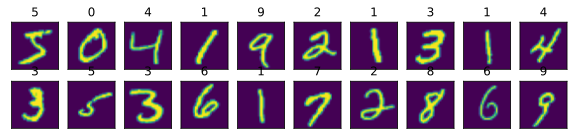

In [78]:
X,y = next(iter(data.DataLoader(mnist_train, batch_size=20)))
show_images(X.reshape(20,28,28),2,10, titles = y.tolist() )

Reading a Minibatch

at each iteration, a data iterator reads a minibatch of data with size batch_size each time. We also randomly shuffle the examples for the
training data iterator.


In [79]:

batch_size = 256
num_workers = 4

# num_workers는 현재 작업하고 있는 환경 내에서 어떤 프로세스에 데이터를 불러올 것인지 조정하는 파라미터입니다.
# 0이 Default값이며, 0은 Main Process에 데이터를 불러오는 것을 의미합니다.
# 만약 Multi-Processing을 이용해서 데이터를 로드할 경우 Process의 개수에 맞게 할당하여 인자값을 조절하기도 합니다.

train_iter = data.DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Putting all things together

In [80]:
def load_data_mnist(batch_size, resize = None):
  """Download the MNIST dataset and ten load it to memory"""
  trans = [transforms.ToTensor()] # list of transform objects - transforms.CenterCrop(10) 이런거 추가해도 됨
  if resize : 
    trans.insert(0, transforms.Resize(resize))

  trans = transforms.Compose(trans) # torchvision.transforms.Compose(list of Transform objects)

  mnist_train = torchvision.datasets.MNIST(root = "../data", train=True, transform = trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root = "../data", train=False, transform = trans, download=True)

  train_loader = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers = 2 )
  test_loader = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle = False, num_workers = 2 )
  return train_loader, test_loader

In [81]:
train_iter, test_iter = load_data_mnist(256,resize=28)

In [82]:
for X,y in train_iter:
  print(X.shape , X.dtype, y.shape, y.dtype)
  break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


## 3.6 Implementation of Softmax Regression from scratch

Initailizing Model Parameters

we will flatten each image,
treating them as vectors of length 784.(28*28)
for now we treat each pixel location as just another feature.

In [83]:
input_dim = 784
output_dim = 10

W = torch.normal(0, 0.01, size=(input_dim,output_dim), requires_grad= True )  #텐서의 모든 연산에 대하여 추적을 시작
b = torch.zeros(output_dim, requires_grad= True)

Defining the Softmax Operation

In [84]:
#sum 함수 작동 방식 이해해보자는 그런 코두ㅡ
X = torch.tensor([[1. ,2. ,3. ],[4. ,5. ,6. ]])
X.sum(0, keepdim= True), X.sum(1,keepdim = True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [85]:
def softmax(X_ij):
    X_ij_exp = torch.exp(X_ij)
    partition = X_ij_exp.sum(1, keepdim=True) # axis 1 : 같은 행끼리 합 
    return X_ij_exp / partition  

In [86]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0265, 0.2065, 0.0713, 0.1581, 0.5376],
         [0.0467, 0.1125, 0.1295, 0.0625, 0.6488]]), tensor([1., 1.]))

Defining the Model

In [87]:
def net(X):
  logit = torch.matmul(X.reshape((-1, W.shape[0])), W) + b  # 행은 자동, 열만 W.shape[0]으로 지정
  return softmax(logit)  


Defining the Loss Function

In [88]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # predicted probabilities of each class
y_hat[[0, 1], y]

# Using y as the indices of the probabilities in y_hat
# we pick the probability of the first class in the first example = (0,1) 
# and the probability of the third class in the second example. = ()

tensor([0.1000, 0.5000])

In [89]:
def cross_entropy(y_hat, y):
  res = y_hat[range(len(y_hat)), y]
  return - torch.log( res )


cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

Classification Accuracy

In [90]:
def accuracy(y_hat, y):  
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [91]:
accuracy(y_hat, y) / len(y)

0.5

In [92]:
def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [93]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [94]:
evaluate_accuracy(net, test_iter)

0.0958

Training

In [95]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  for X, y in train_iter:
      # Compute gradients and update parameters
      y_hat = net(X)
      l = loss(y_hat, y)
      if isinstance(updater, torch.optim.Optimizer):
        # Using PyTorch in-built optimizer & loss criterion
          updater.zero_grad()
          l.mean().backward()
          updater.step()
      else:
        # Using custom built optimizer & loss criterion
          l.sum().backward()
          updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
# Return training loss and training accuracy
  return metric[0] / metric[2], metric[1] / metric[2]

In [96]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
              if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
          self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [97]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [98]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

## 3.7 Using torch function

In [99]:
import torch
from torch import nn
from d2l import torch as d2l
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [105]:
batch_size = 256

# download path 정의
download_root = './MNIST_DATASET'

mnist_transform = transforms.ToTensor()
 

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
train_iter = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
test_iter = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=True)


In [106]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [107]:
loss = nn.CrossEntropyLoss(reduction='none')

In [109]:
trainer = torch.optim.SGD(net.parameters(), lr=0.05)

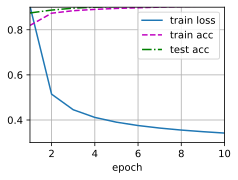

In [110]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)